In [38]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.neighbors import KDTree

In [2]:
hats = pd.read_csv("data_gathering/csv_files/hat_all.csv", index_col=0)
guzergahs = pd.read_csv("data_gathering/csv_files/guzergah_all.csv", index_col=0)

In [3]:
hatkodu = hats[hats.HAT_DURUMU==1].HAT_KODU.to_numpy()

In [48]:
duraks = guzergahs[['DURAKKODU','DURAKADI','XKOORDINATI','YKOORDINATI']].drop_duplicates()

In [49]:
# dk = gpd.GeoSeries.from_wkt(duraks.KOORDINAT)
dk = gpd.GeoSeries.from_xy(duraks.XKOORDINATI, duraks.YKOORDINATI)

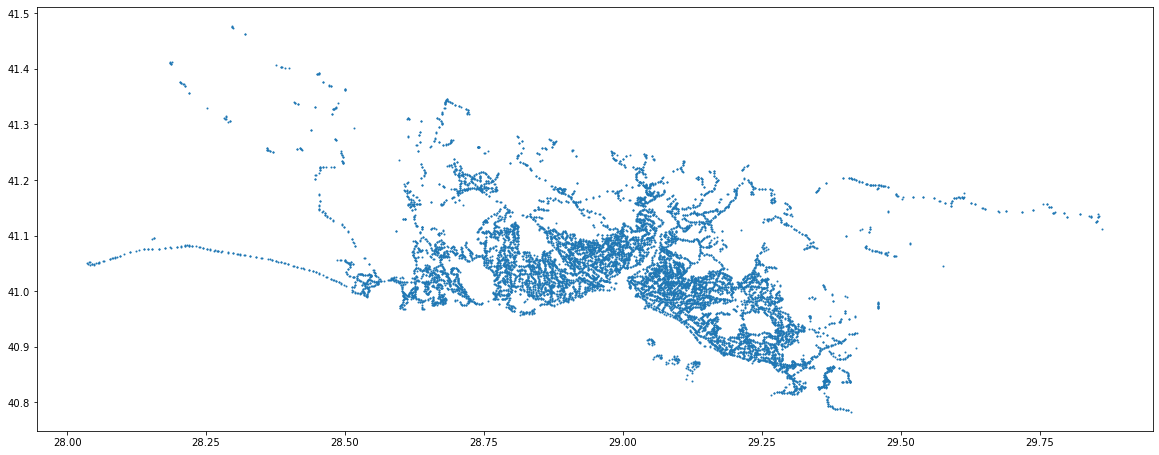

In [50]:
fig, ax = plt.subplots(1, 1, figsize=(20,10))
dk.plot(ax = ax, markersize=1)
plt.show()

In [163]:
# G = nx.DiGraph()
G = nx.Graph()
pos = {kod:(point.x, point.y) for kod, point in zip(duraks.DURAKKODU, dk)}
drk = {kod:durak for kod, durak in zip(duraks.DURAKKODU, duraks.DURAKADI)}

In [164]:
for hat in hatkodu:
    yol = guzergahs[(guzergahs.HATKODU==hat) & (guzergahs.YON=='D')]
    yol = list(zip(yol.SIRANO,yol.DURAKKODU))
    yol = sorted(yol)
    yol = [y[1] for y in yol]
    if len(yol)>1:
        yol = list(zip(yol[:-1], yol[1:]))
        G.add_edges_from(yol)
    
    yol = guzergahs[(guzergahs.HATKODU==hat) & (guzergahs.YON=='G')]
    yol = list(zip(yol.SIRANO,yol.DURAKKODU))
    yol = sorted(yol)
    yol = [y[1] for y in yol]
    if len(yol)>1:
        yol = list(zip(yol[:-1], yol[1:]))
        G.add_edges_from(yol)

In [165]:
nodepos = np.asarray([np.asarray(pos[node]) for node in G.nodes])
tree = KDTree(nodepos)
contract = []
for i, node in enumerate(G.nodes):
    close = tree.query([nodepos[i]], k=2)[1][0][1]
    if drk[node] == drk[list(G.nodes)[close]]:
        pair = sorted((node, list(G.nodes)[close]))
        if pair not in contract:
            contract.append(pair)

print(len(G.nodes))
print(len(contract))

contract = np.asarray(contract)

12463
5403


In [166]:
# for i,(u,v) in enumerate(contract):
#     contracted = contract[i:][contract[i:][:,0]==v]
#     if len(contracted>0):
#         print(i, u, v)
#         contract[i:][contract[i:][:,0]==v][0] = u

In [167]:
for u,v in contract:
    if u in G.nodes and v in G.nodes:
        G = nx.algorithms.minors.contracted_nodes(G, u, v)
    
len(G.nodes)

7185

In [168]:
len(G.edges)

10134

In [169]:
G.remove_edges_from(nx.selfloop_edges(G))
len(G.edges)

10069

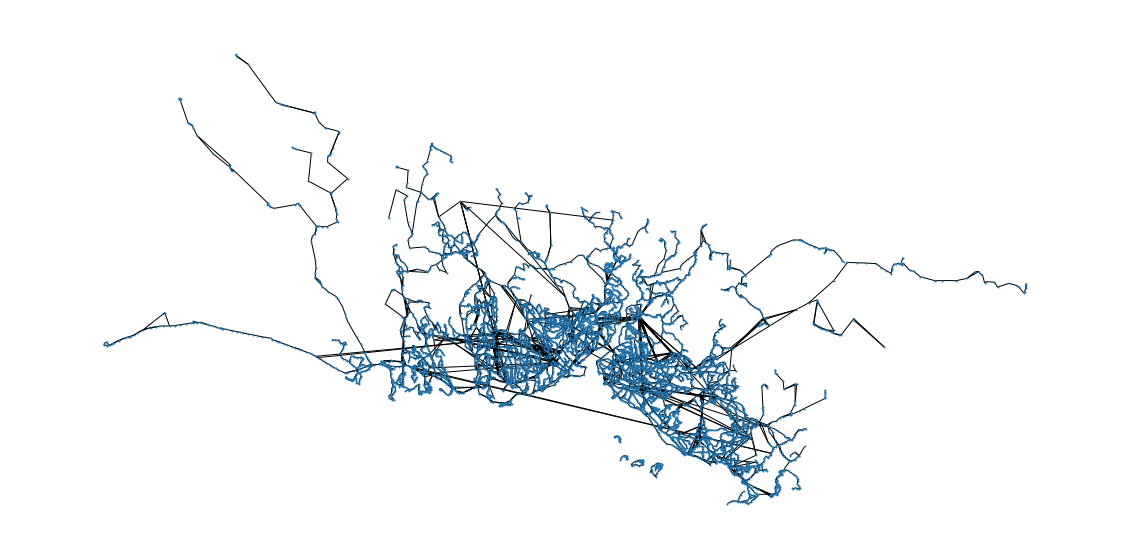

In [170]:
fig, ax = plt.subplots(1, 1, figsize=(20,10))
nx.draw(G, pos=pos, node_size=1, ax=ax)
plt.show()